# Determine real world's factors relate to SS-SOM Data

## Import data:
    We are looking for the relationship between variables in the Census data and hate-crimes data and SS-SOM data  
### SS-SOM data:
    Socio-spatial Self-organizing Maps(SS-SOM) based on SOM, use social media data to find social process geographically. SS-SOM divides geography into small grad cells. Each grid cell contains social media information from Tweeter. After classifing Tweets into target groups, the proportion of target variable in each grid cell would be calculated. For example, base on the keywords represents of racism tweets, the machine would able to put all tweets into two categories, racism tweets, and non-racism tweets. Each tweet has coordination that allows SS-SOM organize tweets into a map, and divided this map into the number of grid cells. Base on SS-SOM calculation, each grid cells weights would be recalculated and be clustered into larger groups. The output is able to be visualized.
    
    The final output of data like this:

In [1]:
%matplotlib inline
import matplotlib


import csv
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import pysal
import xlrd
from matplotlib.lines import Line2D
from shapely.geometry import Polygon, MultiPoint,Point

In [2]:
grid_cell_data = pd.read_csv('final-gred-cell.csv')
print(grid_cell_data.head())

   Grid_ID     Lat     Lon  precinct  zip_code
0        1  40.497 -74.247       123     10307
1        2  40.498 -74.249       123     10307
2        3  40.498 -74.248       123     10307
3        4  40.498 -74.247       123     10307
4        5  40.498 -74.245       123     10307


    For more information of SS-SOM, please look at paper: 
    Socio-spatial Self-organizing Maps: Using Social Media to Assess Relevant Geographies for Exposure to Social Processes.
### Census data:
    U.S. Census Bureau’s “2016 American Community Survey 1-Year Estimates” dataa collected using census reporterb (a website that uses information from the U.S. Census bureau to create place profiles that provide a user-friendly interface for navigating data) was used to fetch zip-code level population data for cities. Census data for 2016 is used as it is the latest available official population estimate data that is closest to the Twitter data for 2017 (January 25, 2017 to November 7, 2017) used in SS-SOM paper. More specifically, census data was collected for covariates that may be strong predictors for the prevalence of racism and homophobia [1,3]: (1) Income level, (2) employment status, and (3) level of education. Further, data giving details about demographics is also used to facilitate exploration of how people and their daily habits affect prevalence of racism and homophobia.
    Census data contains following table and variable:
#### 1.1) Income:
   ##### Table B17020--Poverty Status by Age
    To compare prevalence of racism/homophobia and proportion of population below poverty line (e.g.,  is racism/homophobia and hate-crime more prevalent in areas with higher proportion of below-poverty level as  compared to areas with lower proportion of below-poverty level), the following columns will be used:
    column E - “Income in the past 12 months below poverty level”: proportion of population below poverty level, -73.715,40.82
    column U - “Income in the past 12 months above poverty level”: proportion of population above poverty level -73.715,40.82
    Table B19013--Median Household Income
    To check if racism/homophobia are prevalent more in low income area or high-income area, or there is no relation between income level and racism/homophobia, the following columns will be used:
    column C - “Median household income in the past 12 months” : median household income
#### 1.2) Employment:
   ##### Table B23025--Employment Status for the Population 16 Years and Over
    To check if not being in labor force or not affects the prevalence of racism/homophobia, the following columns will be used:
    column E - “In labor force” : proportion of population in labor force -73.715,40.82
    column O - “Not in labor force”: proportion of population not in labor force 
    To check if unemployment has an effect on racism/homophobia, the following columns will be used:
    column I - “In labor force: -- Civilian labor force: -- Employed” : proportion of employed people in labor force
    column K - “In labor force: -- Civilian labor force: -- Unemployed” : proportion of unemployed people in labor force 
    column M - “In labor force: -- Armed Forces”: proportion of people in labor force who are in armed forces
    Additional table that may be useful to check if the type of job (federal employee, self-owned business owner, etc.) is correlated to prevalence of racism/homophobia
    Table C24060--Occupation by Class of Worker for the Civilian Population

#### 1.3) Education:
   ##### Table B15003-- Educational Attainment

#### 1.4) Demographics:
    All the following tables will be used to check if the basic demographic characteristics like gender, median age, household type (racism/homophobia may be higher in areas with higher proportion of single households as compared to household with families),  race, place of birth or country of ancestry affects the prevalence of racism/homophobia or not.
   ###### Table B01001--Sex by Age
    Column E : “Male”: proportion of male
    Column BA : “Female” : proportion of female

   ###### Table B01002--Median Age by Sex
    Column C : “total” : Median age (in years)

   ###### Table B01003--Total Population
    Column C : “total population” : total population

   ###### Table B02001--Race
    Column E : “White alone” : proportion of white population
    Column G: “Black alone”: proportion of black population
    Column I : “American Indian or Alaska native alone” : proportion of American Indian/Alaska native population
    Column K : “Asian alone” : proportion of asian population
    Column M : “Native Hawaiian or Other Pacific Islander alone ” : proportion of Native Hawaiian population
    Column O : “Some other race alone” : proportion of population of other race
    Column Q : “Two or more races” : proportion of population having two or more races

   ###### Table B03003--Hispanic or Latino Origin
    Column E : “Not Hispanic or Latino”: proportion of non-Hispanic/non-Latino population
    Column G : “Hispanic or Latino”: proportion of Hispanic/Latino population

   ###### Table B04004 -- People Reporting Single Ancestry
    All alternate columns starting from column E: proportion of population with chosen ancestry

   ###### Table B06003-- Place of Birth by Sex in the United States
    Column I + Column O + Column U : People born in USA or natives of USA born in Foreign country : proportion of population born as USA citizens
    Column AA : Foreign born： proportion of population who are foreign born
    Motivation for choosing this table is the fact people who are foreign born and are not accustomed to the culture and lifestyle of the USA are more likely to face racism as compared to people born in USA

   ###### Table B11001--Household Type (Including Living Alone)
    Column E : “Family households” : proportion of family households
    Column O : “Non-family households” : proportion of non-family households
    Motivation for choosing this table is the fact that areas with higher non-family households may have higher prevalence of racism/homophobia

   ###### Table B11009--Unmarried-partner Households by Sex of Partner
    (Column G + Column K)  / Column E : normalized count of households with same-sex partners: proportion of households with same-sex partners
    (Column I + Column M) / Column E : normalized count of households with opposite-sex partners: proportion of households with opposite-sex partners
    We can not find a table describing the sex of partner for households with married couples which may be because same-sex marriages were not legalized in the United states until 2015 and hence, such a table may not be used in 2010 data which is a base used for 2016 data.
    Motivation for choosing this table is based on the intuition that areas with higher number of same-sex partners may have higher prevalence of homophobia
    
#### 1.5) Commute:
##### Table B08301-- Means of Transportation to Work
    Column E + Column AI + Column AK + Column AM + Column AO + Column AQ : number of people who use non-public transport including people who work from home : proportion of population using non-public transport
    Column U + Column AG - number of people who use public transport including taxicab: proportion of population using public transport
    If the total number of people whose commute data available is not same as population, an additional table that may be useful is: Table B99080--Allocation of Means of Transportation to Work
    
    For example, the Table B01003--Total Population like this:

In [3]:
poverty_data = pd.read_csv('Table B01003--Total Population NewYork.csv')
print(poverty_data.head())

            geoid      zip code  Total Population  Error for Total Population
0  16000US3651000  New York, NY           8461961                           0
1    86000US07002          7002             65772                          47
2    86000US07008          7008             23966                          43
3    86000US07020          7020             11998                          55
4    86000US07024          7024             36625                          45


### Hate Crime data:
    Collecting Hate Crime data for different cities from Police Departments. Hate crime is open data. Each city has low amount number of Hate Crime. As the result, hate crime data from the year 2010 to 2018 has been collected. For different cities, the format and geography level for hate crime data are very different. 

## Organizing data：
    There are three steps in this process.
    First is census data should be organized into one table by zip code level
    The second step is Hate-Crime data should be organized into one table by precinct level
    The last step is organizing grid cell table. For each grid cell, corresponding census data and hate-crime data should be added. As result, before adding the data, each grid cell should be given zip code and precinct.

In [4]:
import xlwt
import xlrd
from xlutils.copy import copy

dic_convert_columns_to_numbers= {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
                                     'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18,
                                     'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25,
                                     'AA': 26, 'AB': 27, 'AC': 28, 'AD': 29, 'AE': 30, 'AF': 31, 'AG': 32, 'AH': 33,
                                     'AI': 34, 'AJ': 35, 'AK': 36, 'AL': 37, 'AM': 38, 'AN': 39, 'AO': 40, 'AP': 41,
                                     'AQ': 42, 'AR': 43, 'AS': 44, 'AT': 45, 'AU': 46, 'AV': 47, 'AW': 48, 'AX': 49,
                                     'AY': 50, 'AZ': 51,'BA':52,'BB':53}

filename_table = {
        "Table B23025--Employment Status for the Population 16 Years and Over" : (['E','O','I','K','M'],'p'),
        "Table B19013--Median Household Income":(['C'],'n'),
        "Table B17020--Poverty Status by Age":(['E','U'],'p') ,
        "Table B11001--Household Type (Including Living Alone)":(['E','O'],'p' ),
        "Table B03003--Hispanic or Latino Origin":(['E','G'],'p') ,
        "Table B02001--Race":(['E','G','I','K','M','O','Q'],'p') ,
        "Table B01003--Total Population":(['C'],'n') ,
        "Table B01002--Median Age by Sex":(['C'],'n') ,
        "Table B01001--Sex by Age":(['E','BA'],'p'),
        "Table B06003-- Place of Birth by Sex in the United States":(['AA'],'p'),
        "Table B15003-- Educational Attainment":(['E','G','AE','AG','AI','AK','AM','AO','AQ','AS','AU','AW','AY'],'p')
    }

filename_table_with_addition = {
        "Table B06003-- Place of Birth by Sex in the United States" : [(['I','O','U'],"proportion of population born as USA citizens")],
        "Table B11009--Unmarried-partner Households by Sex of Partner" : [(['G','K'],'proportion of households with same-sex partners'),(['I','M'],'proportion of households with opposite-sex partners')],
        "Table B08301-- Means of Transportation to Work" : [(['E','AI','AK','AM','AO','AQ'],'proportion of population using non-public transport'),(['U','AG'],' proportion of population using public transport')],
    }

 ### Organizing Census data in zip code level
    Each table downloaded from census reporter did not have tital name for each column.
    Get all the tital names manuly from census reporters, and list them into each column.

In [5]:
def make_list(lst):
    out_lst = ['geoid','zip code']
    for i in lst:
        out_lst.append(i)
        out_lst.append("Error for " + i)
    return out_lst

In [6]:
def compelet_table_tital(filename):
    data = xlrd.open_workbook(filename)
    table = data.sheets()[0]
    ncols = table.ncols
    lst_of_change = make_list(lst)
    rb = xlrd.open_workbook(file)
    wb = copy(rb)
    ws = wb.get_sheet(0)
    for i in range(ncols):
        ws.write(0,i,lst_of_change[i])
    newFileName = "changed" + filename
    wb.save(newFileName)

    changing all xlsx formate to csv formate

In [7]:
def csv_from_excel(filename):
    filename_xls = filename + ".xlsx"
    filename_csv = filename + '.csv'

    data = pd.read_excel(filename_xls,index_col=None)
    data.to_csv(filename_csv,encoding = 'utf-8')

In [8]:
def excel_read(doc):
    data = xlrd.open_workbook(doc)
    table = data.sheets()[0]
    return table

    In each data table, many of zip codes are not in the region we define, so we have give a zip code list for the city, and use this list to get geographical coordinates from table that contain all the zip code with geographical coordinates

In [9]:
def zip_code_list_gather(zip_code_file_name):
    workbook = pd.read_csv(zip_code_file_name)
    zip_list_frame = pd.DataFrame(workbook)
    lst_for_zip_code = []
    for i in range(len(zip_list_frame)):
        lst_for_zip_code.append(str(int(zip_list_frame.loc[i,'zip code'])))
    return lst_for_zip_code

In [10]:
def data_frame_zip_code(filename,zip_code_file_name):
    workbook = pd.read_csv(filename)
    dataFrame = pd.DataFrame(workbook)
    dataFrame = dataFrame.rename(index=str, columns={"zip code": "zip_code"})
    zip_code_required = zip_code_list_gather(zip_code_file_name)
    dataFrame = dataFrame[dataFrame.zip_code.isin(zip_code_required)]
    return dataFrame

    Data_columns_for_measuring is function that get the columns name for table. In each table, we are not using all the variables, so we have to seclect whcih one to use. This step is for tell the DataFrame contains all the data only select the required columns

In [11]:
def data_columns_for_measuring(data,number):
    data_columns = list(data.columns.values)
    return data_columns[number]

    For different table, requirement for variables are different. 
    For some variables, we only want variable be proportion, which use function data_frame_with_proportion. 
    For some variables, we only want actual numberof variables, so we have to use function data_frame_with_number. 
    For some table, we want to add some variables to get a new variable in proportion, so we have to use function data_frame_with_addition_proportion
    
    parameters:
    dataFrame: the data frame from table with zip codes we wants, containing all variables in that table
    list_columns: selected variables corresponding columns number in this list.
    name_of_addition: only for function data_frame_with_addition_proportion. Given a new name for new columns affter adding
    
    output:
    data frame with defined zip code and selected variables

In [12]:
def data_frame_with_proportion(dataFrame,list_columns):
    outDataFrame = pd.DataFrame()
    outDataFrame['zip_code'] = dataFrame['zip_code'].astype('int64')
    total_in_DF = dataFrame[data_columns_for_measuring(dataFrame,2)]
    for i in list_columns:
        columns = data_columns_for_measuring(dataFrame,i)
        outDataFrame[columns] = dataFrame[columns].abs()/total_in_DF.abs()

    outDataFrame.fillna(0,inplace=True)
    return outDataFrame
def data_frame_with_number(dataFrame,list_columns):
    outDataFrame = pd.DataFrame()
    outDataFrame['zip_code'] = dataFrame['zip_code'].astype('int64')
    for i in list_columns:
        columns = data_columns_for_measuring(dataFrame, i)
        outDataFrame[columns] = dataFrame[columns].astype('int64')
    return outDataFrame
def data_frame_with_addition_proportion(dataFrame,list_columns,name_of_addition):
    outDataFrame = pd.DataFrame()
    outDataFrame['zip_code'] = dataFrame['zip_code'].astype('int64')
    total_in_DF = dataFrame[data_columns_for_measuring(dataFrame,2)]
    outDataFrame[name_of_addition] = [0]*len(dataFrame)
    for i in list_columns:
        columns = data_columns_for_measuring(dataFrame,i)
        outDataFrame[name_of_addition] += dataFrame[columns].abs()

    outDataFrame[name_of_addition] = outDataFrame[name_of_addition].abs()/total_in_DF.abs()
    outDataFrame.fillna(0,inplace= True)
    return outDataFrame

    Put all census tables with required variables and zip codes together by merge in the column: zip_code
    
    input:
    zip_code_table: data frame only has one column: zip_code
    filename_table: a dictionary. key is table name, 

In [13]:
def organize_census_table_by_zip_code(zip_code_table,filename_table,dic_convert_columns_to_numbers,filename_table_with_addition,zip_code_file,city):
    zip_code_table = zip_code_table
    for key in filename_table:
        city_key = key + ' ' + city + '.csv'
        table_list_number = []
        for i in filename_table[key][0]:
            if i in dic_convert_columns_to_numbers.keys():
                table_list_number.append(dic_convert_columns_to_numbers[i])
        value_table = data_frame_zip_code(city_key,zip_code_file)
        if filename_table[key][1] == 'p':
            value_dataFrame = data_frame_with_proportion(value_table,table_list_number)
        elif filename_table[key][1] == 'n':
            value_dataFrame = data_frame_with_number(value_table,table_list_number)
        
        zip_code_table = zip_code_table.merge(value_dataFrame,on = 'zip_code',how='left')
        
    for key in filename_table_with_addition:
        city_key = key + ' ' + city + '.csv'
        table_list_number_with_addition = []
        for i in filename_table_with_addition[key]:
            columns_name = i[1]
            for k in i[0]:
                if k in dic_convert_columns_to_numbers.keys():
                    table_list_number_with_addition.append(dic_convert_columns_to_numbers[k])
        value_table_with_addition = data_frame_zip_code(city_key,zip_code_file)
        value_dataFrame = data_frame_with_addition_proportion(value_table_with_addition,table_list_number_with_addition,columns_name)
        zip_code_table = zip_code_table.merge(value_dataFrame,on = 'zip_code',how='left')
    return zip_code_table

### Organizing Hate-Crime Data
    Because of the differences of different cities Hate-Crime data formates, the organization would be different.

### Grid Cell Data Merge
    We need to organize each grid cells into zip code level and hate-crime data mapping level

#### Grid Cell Data Merge zip code
    First mapping with zip code.
    Zip code should have corresponding geographical coordinates.
    Grid Cell has coordinates. Determining grid cell in which zip code area, and giving that zip code to that grid cell

    Get all zip code Geographical coordinates from US zip code geographical coordinates. The reading file is shapefile from census 

In [14]:
def all_geod():
    us_geod = gp.GeoDataFrame.from_file('cb_2017_us_zcta510_500k.shp')
    us_geod = us_geod.rename(index=str, columns={"ZCTA5CE10": "zip_code"})
    return us_geod

us_geod = all_geod()
print(us_geod.zip_code.head())
print(us_geod.geometry.head())

0    35442
1    85365
2    71973
3    95445
4    06870
Name: zip_code, dtype: object
0    (POLYGON ((-88.252618 32.92675, -88.249724 32....
1    (POLYGON ((-114.684663 32.687389, -114.676063 ...
2    POLYGON ((-94.46643176650841 34.330735, -94.46...
3    POLYGON ((-123.643051 38.851233, -123.641401 3...
4    POLYGON ((-73.58765810889219 41.0076522198727,...
Name: geometry, dtype: object


    Get city's zip code location

In [15]:
def city_geod(city_zip_code_file):
    us_geod = all_geod()
    zip_code_required = zip_code_list_gather(city_zip_code_file)
    area_geod = us_geod[us_geod.zip_code.isin(zip_code_required)]
    return area_geod

    Determining grid cell in which zip code area, and giving that zip code to that grid cell

In [16]:
def grid_cell_geod_zip_code(city_grid_cell_file,city_zip_code_file):
    city_zip_geod = city_geod(city_zip_code_file)
    poly = city_zip_geod.geometry
    city_grid_cell = pd.read_csv(city_grid_cell_file)
    city_grid_cell['zip_code'] = [0]*len(city_grid_cell)
    for grid_cell_number in range(len(city_grid_cell)):
        points = np.array([(city_grid_cell.Lon[grid_cell_number],city_grid_cell.Lat[grid_cell_number])])
        inside_points = np.array([poly.contains(Point(x,y)) for x, y in points])
        if any(inside_points[0]):
            position = np.where(inside_points)[1][0]
            city_grid_cell.loc[grid_cell_number,'zip_code'] = city_zip_geod.ix[position,'zip_code']
        else:
            city_grid_cell.loc[grid_cell_number,'zip_code'] = 0

#### Error Correction for Grid Cell Data Merge zip code
    First filtrating out the error grid cells that do not have zip code.
    manually finding zip codes for these error grid cells, using website:
    

    For function correct_table:
    
    input:
    data_frame1 is the table contains all grid cells incoulding error grid cells
    data_frame2 contains only error grid cells with correct corresponding zip code 
    
    output:
    data_frame1 contains all grid cells with all correct corrsponding zip code

In [17]:
def correct_table(data_frame1,data_frame2):
    required_position = []
    for j in range(len(data_frame1)):
        if data_frame1.loc[j,'zip_code'] == 0:
            required_position.append(j)

    for i in range(len(required_position)):
        if data_frame1.loc[required_position[i],'Lat'] == data_frame2.loc[i,'Lat'] and data_frame1.loc[required_position[i],'Lon'] == data_frame2.loc[i,'Lon']:
            data_frame1.loc[required_position[i],'zip_code'] = data_frame2.ix[i,'zip_code']

    return data_frame1

#### Grid Cell Data merge with Hate-crime Data map
    Hate-crime data map required
    Grid Cell data table

In [18]:
def grid_cell_geod_hate_crimes(city_grid_cell_file,city_police_area_file):
    PCT_geod = gp.GeoDataFrame.from_file(city_police_area_file)
    grid_cell = pd.read_csv(city_grid_cell_file)
    grid_cell_geod = gp.GeoDataFrame(grid_cell)
    poly = PCT_geod.geometry
    grid_cell_geod['precinct'] = [0]*len(grid_cell_geod)
    grid = grid_cell_geod
    
    for i in range(len(grid)):
        points = np.array([(grid.Lon[i], grid.Lat[i])])
        inside_points = np.array([poly.contains(Point(x, y)) for x, y in points])

        if any(inside_points[0]):
            position = np.where(inside_points)[1][0]
            grid.loc[i,'precinct'] = PCT.ix[position, 'precinct']
        else:
            grid.loc[i,'precinct'] = 0
        print("number " + str(i) + ': position is ' + str(position) + ". precinct is: " + str(grid.loc[i,'precinct']))
        return grid

## Analysis Data
    After having tables contains all the data in the different level, we could do many analysis.
    
    The first analysis is directly visualizing the Data in the different level, so we can determine that some real world's factors have the relationship with SS-SOM data.
    
    The second analysis is drawing correlograms and does convarete analysis between different social factors, and determining the relationship between these factors.
    
    The third analysis is the linear regression for grid cell level of data, trying to find which factor has most relevancy between grid cell level of SS-SOM data and real world's factors 

### Visualizing Data
    We want to visualizing all required variables for Census tables, as well as hate crime tables

#### Visualizing Census data

    Draw action happens in this draw function. 
    geod_table is the table contain all the data after merged. pandas DataFrame type
    data_columns is the which columns that use to show the data in the graph,which is string type indicate pandas or geopandas Series
    data_columns_name is for show the map name in which specific columns in table, always combine with table_name in the picture, which is string type
    k stands for the number of group that all data separate into, which is int type
    figsize stands for how large the pic will be,which has to be in tuple, usually (16,16)
    table name stands for the big name of the pic, always combines with data_columns_name, string type
    units stands for what units showing in the pic, string type, changing with figsize change

In [19]:
def draw(geod_table,data_columns,data_column_name,k,figsize,table_name,units ):
    geod_table.plot(data_columns,k=k,cmap = plt.cm.RdYlGn_r,scheme= 'equal_interval',figsize=figsize,categorical=False,legend = True,edgecolor = 'black')
    table_name_add = table_name + "--" + data_column_name
    print(table_name_add)
    if ":" not in table_name_add:
        if "/" not in table_name_add:
            save_name = table_name_add + '.png'
    else:
        save_name = ''
        print('d')
        for k in table_name_add:
            if k == ':':
                save_name += "--"
            elif k == '/':
                save_name+='--'
            else:
                save_name+=k
        save_name += '.png'
    plt.title(table_name_add, fontsize=20)
    #where put the units text
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.show()

### covariate analysis
    Finding any variable that having high covariation with other variables. Considering higher than 0.7 and below -0.7 be high covariation.

In [20]:
def correlationHeatMap(dataset):
    c_mat = dataset.corr()    
    variable_dic = []
    for variable in c_mat:
        variable_dic.append((variable,[]))
    for i in range(len(c_mat)):
        for j in variable_dic:
            measure = j[0]
            if c_mat.ix[i,measure] >= 0.7 or c_mat.ix[i,measure] <= -0.7:
                variable_dic[i][1].append(measure)
            
            if c_mat.ix[i,measure] == 1.0:
                variable_dic[i][1].pop()
            
                
    return variable_dic                

### New York
    zip code table:

In [21]:
workbook = pd.read_csv("NYC zip code.csv")
new_york_zip_code_data_frame = pd.DataFrame(workbook)
new_york_zip_code_data_frame = new_york_zip_code_data_frame.rename(index=str, columns={"zip code": "zip_code"})
print(new_york_zip_code_data_frame.head())

   zip_code
0     11102
1     11103
2     11357
3     11104
4     11217


#### New York Census Data and graph example 

White along - census--White alone


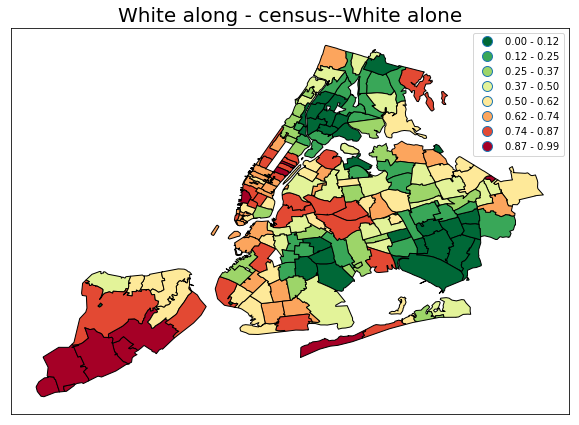

In [22]:
new_york_zip_code_data = organize_census_table_by_zip_code(new_york_zip_code_data_frame,filename_table,dic_convert_columns_to_numbers,filename_table_with_addition,'NYC zip code.csv','NewYork')
new_york_zip_code_location = city_geod('NYC zip code.csv')
new_york_zip_code_location['zip_code'] =new_york_zip_code_location['zip_code'].astype('int64') 
new_york_census = new_york_zip_code_location.merge(new_york_zip_code_data,on='zip_code',how='left')
draw(new_york_census,'White alone','White alone',8,(10,10),'White along - census','pro')

#### New York Hate Crime Data and graph example 

In [23]:
new_york_hate_crime_data = pd.read_csv('hate-crime-2017-NewYork.csv')
new_york_hate_crime_data = new_york_hate_crime_data.rename(index=str, columns={"PRECINCT":"precinct"})
new_york_hate_crime_giod = gp.GeoDataFrame.from_file('geo_export_5f134438-a183-4aaf-866c-3b3175aececc.shp')
new_york_hate_crime = new_york_hate_crime_giod.merge(new_york_hate_crime_data,on = 'precinct')
print(new_york_hate_crime.head())

   precinct    shape_leng    shape_area  \
0       1.0  80586.154615  4.730176e+07   
1       5.0  18676.124259  1.808880e+07   
2       6.0  27182.610113  2.213193e+07   
3       7.0  17301.308682  1.836402e+07   
4       9.0  19773.233410  2.139423e+07   

                                            geometry  60 YEARS OLD OR MORE  \
0  (POLYGON ((-74.0438776157395 40.69018767637665...                   0.0   
1  POLYGON ((-73.98863862848766 40.72293372026369...                   0.0   
2  POLYGON ((-73.99968392160721 40.73855224865976...                   0.0   
3  POLYGON ((-73.97345389423181 40.718962954076, ...                   0.0   
4  POLYGON ((-73.97160900246391 40.72672340116989...                   0.0   

   ANTI-ARAB  ANTI-ASIAN  ANTI-BLACK  ANTI-CATHOLIC  \
0        0.0         0.0         0.0            1.0   
1        0.0         0.0         0.0            0.0   
2        0.0         1.0         2.0            0.0   
3        0.0         0.0         0.0            0.0 

Total for NY hate crime for year 2017--Total


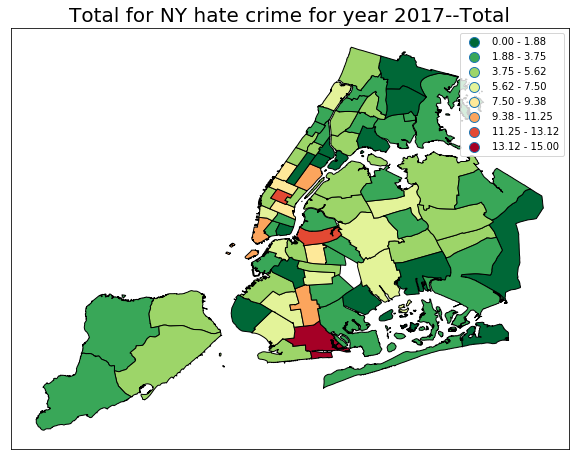

In [24]:
draw(new_york_hate_crime,'Total','Total',8,(10,10),'Total for NY hate crime for year 2017','pro')

#### covariate analysis for new york

In [25]:
corr_table_for_NY=correlationHeatMap(new_york_zip_code_data)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


following is covariate table for new york. In each [[[]]], high covariation variable has been list

In [26]:
for i in corr_table_for_NY:
    if i[1] != []:
        str_l = ''
        for k in i[1]:
            str_l += '(' + k + ')'
        print(i[0] + ' has high covariation with :' + "[[[" +str_l +"]]]"+'\n')
    else:
        continue

White alone has high covariation with :[[[(Bachelor's degree)(Master's degree)(Median household income in the past 12 months)]]]

Some other race alone has high covariation with :[[[(Hispanic or Latino)]]]

,Family households: has high covariation with :[[[(Income in the past 12 months above poverty level:)(Foreign born:)(In labor force:)(Not in labor force:)(Regular high school diploma)(Some college, 1 or more years, no degree)(Associate's degree)(Median Age)(,Male:)(Female:)( proportion of population using public transport)]]]

Nonfamily households: has high covariation with :[[[(Income in the past 12 months above poverty level:)(In labor force:)(In labor force: -- Civilian labor force: -- Employed)(Bachelor's degree)(Master's degree)(Professional school degree)(Female:)(proportion of population born as USA citizens)]]]

Income in the past 12 months below poverty level: has high covariation with :[[[(In labor force: -- Civilian labor force: -- Unemployed)(11th grade)(12th grade, no d

### Seattle
    zip code table:
        all census table for seattle and required variables

In [27]:
workbook = pd.read_csv("Seattle zip code.csv")
seattle_zip_code_data_frame = pd.DataFrame(workbook)
seattle_zip_code_data_frame = seattle_zip_code_data_frame.rename(index=str, columns={"zip code": "zip_code"})
print(seattle_zip_code_data_frame.head())

   zip_code
0     98101
1     98102
2     98103
3     98104
4     98105


#### Seattle Census Data and graph example 

White along - census--White alone


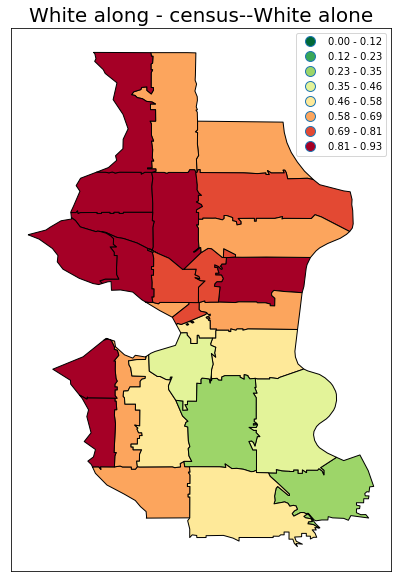

In [28]:
seattle_zip_code_data = organize_census_table_by_zip_code(seattle_zip_code_data_frame,filename_table,dic_convert_columns_to_numbers,filename_table_with_addition,'Seattle zip code.csv','Seattle')
seattle_zip_code_location = city_geod('Seattle zip code.csv')
seattle_zip_code_location['zip_code'] =seattle_zip_code_location['zip_code'].astype('int64')
seattle_census = seattle_zip_code_location.merge(seattle_zip_code_data,on='zip_code',how='left')
draw(seattle_census,'White alone','White alone',8,(10,10),'White along - census','pro')

#### Seattle Hate-crimes data

In [29]:
def data_merge(filename,geod):
    dic = {'ALASKA JUNCTION':0,'ALKI':1,'BALLARD NORTH':2,'BALLARD SOUTH':3,'BELLTOWN':4,'BITTERLAKE':5,'BRIGHTON/DUNLAP':6,'CAPITOL HILL':7,'CENTRAL AREA/SQUIRE PARK':8,'CLAREMONT/RAINIER VISTA':9,'COLUMBIA CITY':10,'COMMERCIAL DUWAMISH':11,'COMMERCIAL HARBOR ISLAND':12,'DOWNTOWN COMMERCIAL':13,
           'HILLMAN CITY':14,'EASTLAKE - EAST':15,'EASTLAKE - WEST':16,'FAUNTLEROY SW':17,'FIRST HILL':18,'FREMONT':19,'GENESEE':20,'GEORGETOWN':21,'GREENWOOD':22,'HIGH POINT':23,'HIGHLAND PARK':24,'CHINATOWN/INTERNATIONAL DISTRICT':25,'INTERNATIONAL DISTRICT - WEST':26,
           'JUDKINS PARK':27,'LAKECITY':28,'LAKEWOOD/SEWARD PARK':29,'MADISON PARK':30,'MADRONA/LESCHI':31,'MAGNOLIA':32,'MID BEACON HILL':33,'MILLER PARK':34,'MONTLAKE/PORTAGE BAY':35,'MORGAN':36,'MOUNT BAKER':37,'MT BAKER/NORTH RAINIER':38,'NEW HOLLY':39,'NORTH ADMIRAL':40,'NORTH BEACON HILL':41,
           'JUDKINS PARK/NORTH BEACON HILL':42,'NORTH CAPITOL HILL':43,'NORTH DELRIDGE':44,'NORTHGATE':45,'PHINNEY RIDGE':46,'PIGEON POINT':47,'PIONEER SQUARE':48,'QUEEN ANNE':49,'RAINIER BEACH':50,'RAINIER VIEW':51,'ROOSEVELT/RAVENNA':52,'ROXHILL/WESTWOOD/ARBOR HEIGHTS':53,'SANDPOINT':54,'SLU/CASCADE':55,
           'SODO':56,'SOUTH BEACON HILL':57,'SOUTH PARK':58,'UNIVERSITY':59,'WALLINGFORD':60
    }
    dataFrame = pd.read_csv(filename)
    for i in range(len(dataFrame)):
        if dataFrame.ix[i,'Neighborho'] in dic.keys():
            key = dataFrame.ix[i,'Neighborho']
            bias_type = 'anti-' + dataFrame.ix[i, 'Specific Bias Category']
            if bias_type == 'anti-Black, White':
                bias_type = 'anti-Multiple Races'
            elif bias_type == 'anti-Other Race/Ethnicity/Ancestry':
                bias_type = 'anti-Multiple Races'
            elif bias_type == 'anti-Native American/Alaska Native':
                bias_type = 'anti-Multiple Races'
            elif bias_type == 'anti-Race-Unspecified':
                bias_type = 'anti-Gender Non-Conforming'
            elif bias_type == 'anti-American Indian/Alaska Native':
                bias_type = 'anti-Asian'
            elif bias_type == 'anti-Gay & Lesbian':
                bias_type = 'anti-Gay/Lesbian'
            elif bias_type == 'anti-Homosexual':
                bias_type = 'anti-Gay/Lesbian'
            elif bias_type == 'anti-Sexual Identity':
                bias_type = 'anti-Bisexual'
            elif bias_type == 'anti-Heterosexual':
                bias_type = 'anti-Gay/Lesbian'
            if key == 'CHINATOWN/INTERNATIONAL DISTRICT':
                value1 = dic[key]
                value2 = dic[key]+1
                geod.ix[value1, bias_type] = geod.ix[value1, bias_type] + 1
                geod.ix[value2, bias_type] = geod.ix[value2, bias_type] +1
 
            else:
                value = dic[key]
                geod.ix[value,bias_type] = geod.ix[value,bias_type] + 1
        else:
            print('ERROR: ///////// ' +dataFrame.ix[i,'Neighborho'])
            
    return geod




In [30]:
file_list = ['Crime_Cat_Table_data_2018_racism',
           'Crime_Cat_Table_data_2018_LGBTQ',
           'Crime_Cat_Table_data_2017_racism',
           'Crime_Cat_Table_data_2017_LGBTQ',
           'Crime_Cat_Table_data_2016_racism',
           'Crime_Cat_Table_data_2015_LGBTQ',
           'Crime_Cat_Table_data_2015_racism',
           'Crime_Cat_Table_data_2014_LGBTQ',
           'Crime_Cat_Table_data_2013_racism',
           'Crime_Cat_Table_data_2013_LGBTQ',
           'Crime_Cat_Table_data_2012_racism',
           'Crime_Cat_Table_data_2012_LGBTQ'
           ]
seattle_geod = gp.GeoDataFrame.from_file('geo_export_9a0ace33-b0ae-4ee5-8a21-6e4132d8262a.shp')
seattle_geod = seattle_geod.rename(index=str, columns={"name": "Neighborho"})

seattle_geod['anti-Asian'] = [0]*len(seattle_geod)
seattle_geod['anti-Asian/Pacific Islander'] = [0] * len(seattle_geod)
seattle_geod['anti-Black'] = [0]*len(seattle_geod)
seattle_geod['anti-Hispanic'] = [0]* len(seattle_geod)
seattle_geod['anti-White'] = [0]*len(seattle_geod)
seattle_geod['anti-Bisexual'] = [0]*len(seattle_geod)
seattle_geod['anti-Gay'] = [0] * len(seattle_geod)
seattle_geod['anti-Gay/Lesbian'] = [0]*len(seattle_geod)
seattle_geod['anti-Gender Non-Conforming'] = [0] *len(seattle_geod)
seattle_geod['anti-Lesbian'] = [0] * len(seattle_geod)
seattle_geod['anti-Transgender'] = [0] * len(seattle_geod)
seattle_geod['anti-Multiple Races'] = [0] * len(seattle_geod)
seattle_geod['anti-Gender'] = [0] * len(seattle_geod)


for i in file_list:
    file = i + ".csv"
    seattle_geod = data_merge(file,seattle_geod)
    


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0

ERROR: ///////// SOUTH DELRIDGE


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Hate-crime--anti-Black


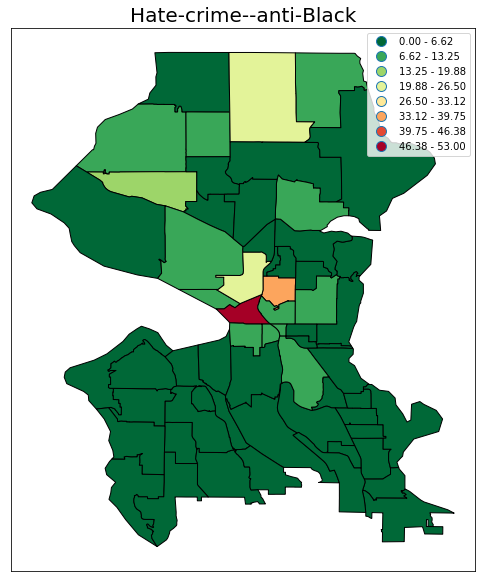

In [31]:
draw(seattle_geod,'anti-Black','anti-Black',8,(10,10),'Hate-crime','pro')

Hate-crime--anti-White


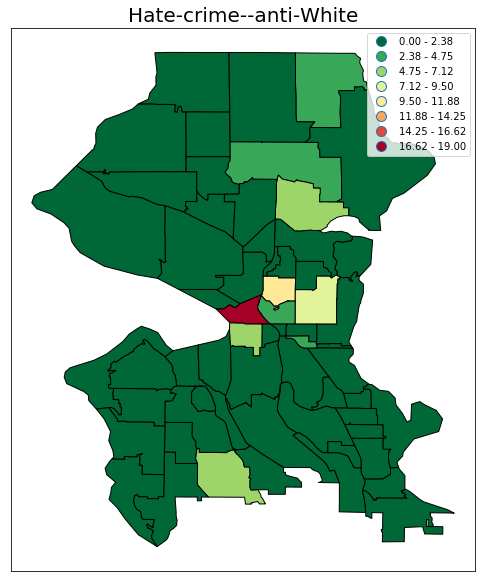

In [32]:
draw(seattle_geod,'anti-White','anti-White',8,(10,10),'Hate-crime','pro')

Hate-crime--anti-Asian


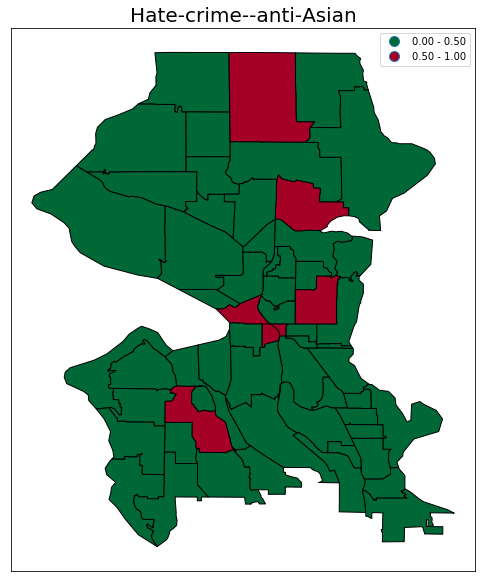

In [33]:
draw(seattle_geod,'anti-Asian','anti-Asian',2,(10,10),'Hate-crime','pro')

Hate-crime--anti-Asian/Pacific Islander


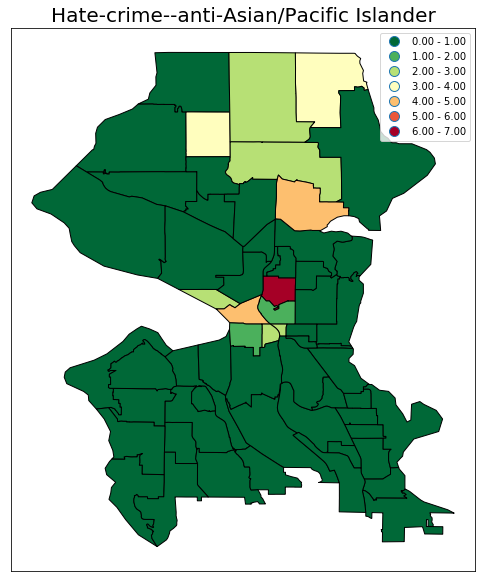

In [34]:
draw(seattle_geod,'anti-Asian/Pacific Islander','anti-Asian/Pacific Islander',7,(10,10),'Hate-crime','pro')

Hate-crime--anti-Hispanic


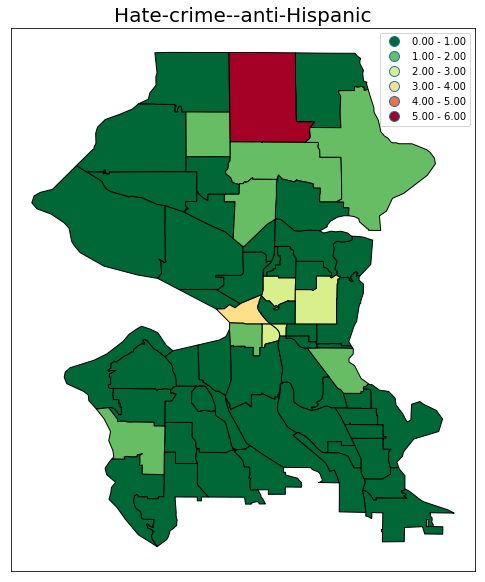

In [35]:
draw(seattle_geod,'anti-Hispanic','anti-Hispanic',6,(10,10),'Hate-crime','pro')

Hate-crime--anti-White


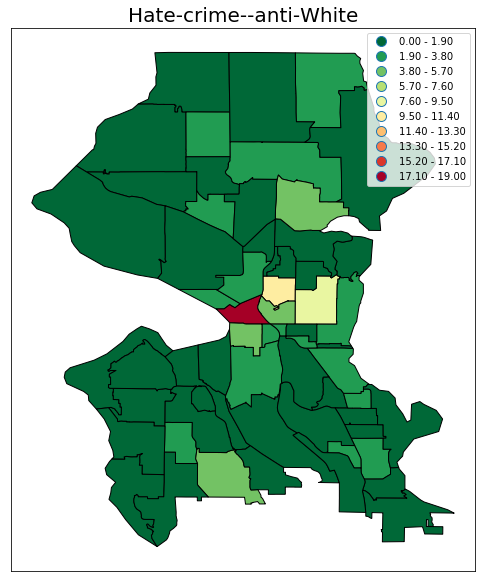

In [36]:
draw(seattle_geod,'anti-White','anti-White',10,(10,10),'Hate-crime','pro')

Hate-crime--anti-Bisexual


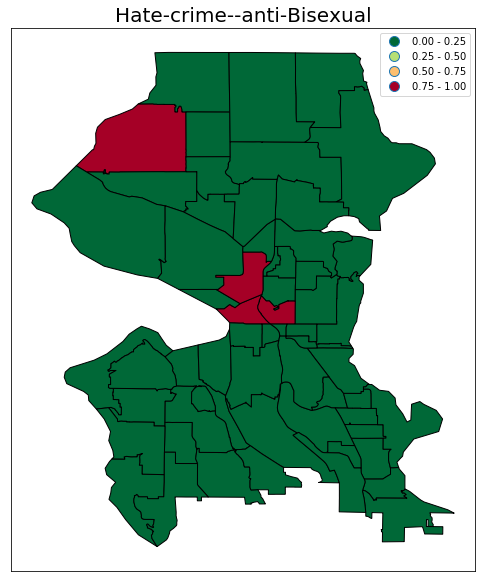

In [37]:
draw(seattle_geod,'anti-Bisexual','anti-Bisexual',4,(10,10),'Hate-crime','pro')

Hate-crime--anti-Gay


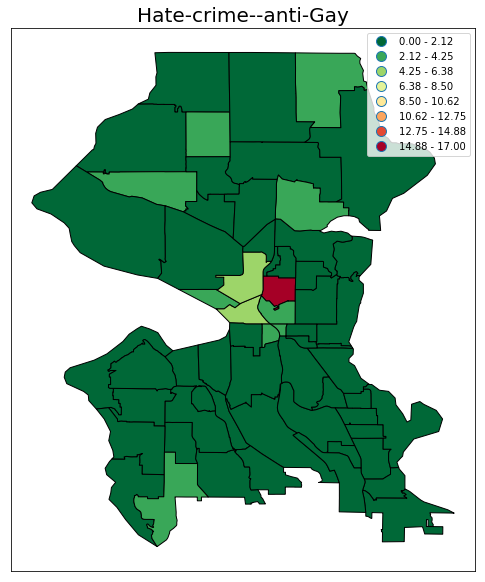

In [38]:
draw(seattle_geod,'anti-Gay','anti-Gay',8,(10,10),'Hate-crime','pro')

Hate-crime--anti-Gay/Lesbian


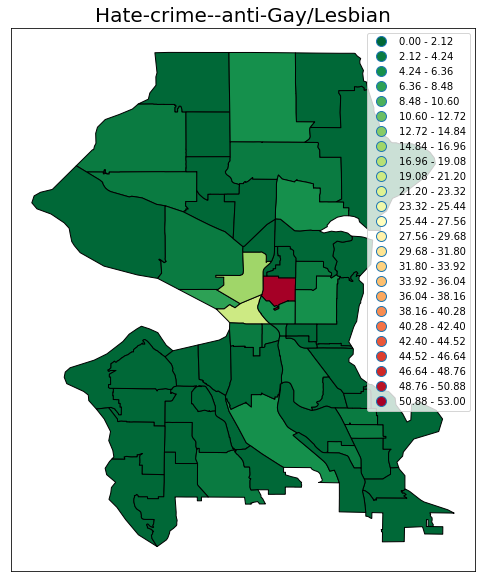

In [39]:
draw(seattle_geod,'anti-Gay/Lesbian','anti-Gay/Lesbian',25,(10,10),'Hate-crime','pro')

Hate-crime--anti-Gender Non-Conforming


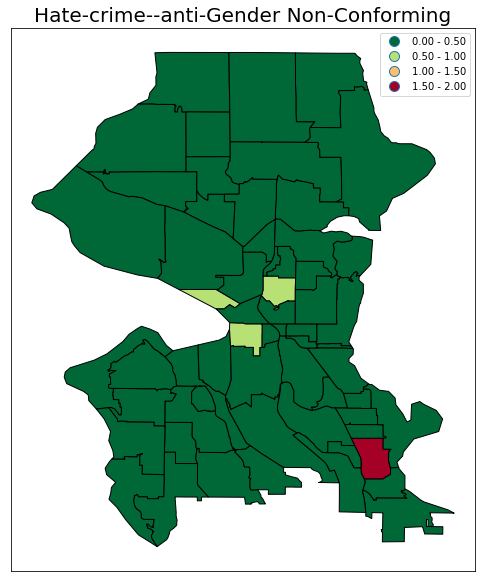

In [40]:
draw(seattle_geod,'anti-Gender Non-Conforming','anti-Gender Non-Conforming',4,(10,10),'Hate-crime','pro')

Hate-crime--anti-Lesbian


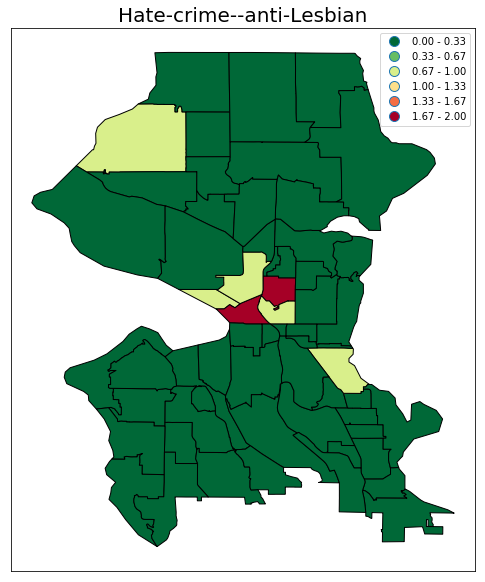

In [41]:
draw(seattle_geod,'anti-Lesbian','anti-Lesbian',6,(10,10),'Hate-crime','pro')

Hate-crime--anti-Transgender


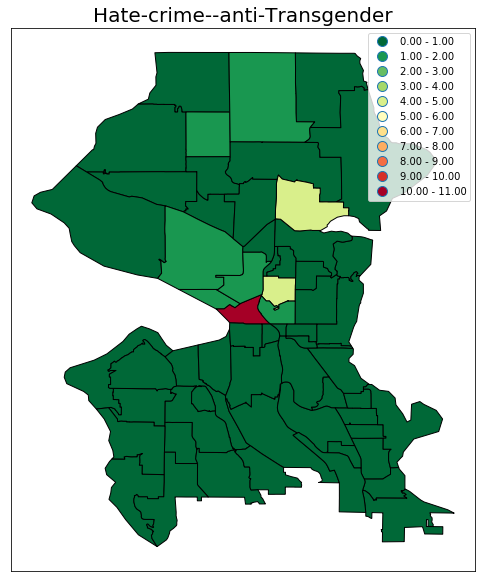

In [42]:
draw(seattle_geod,'anti-Transgender','anti-Transgender',11,(10,10),'Hate-crime','pro')

Hate-crime--anti-Multiple Races


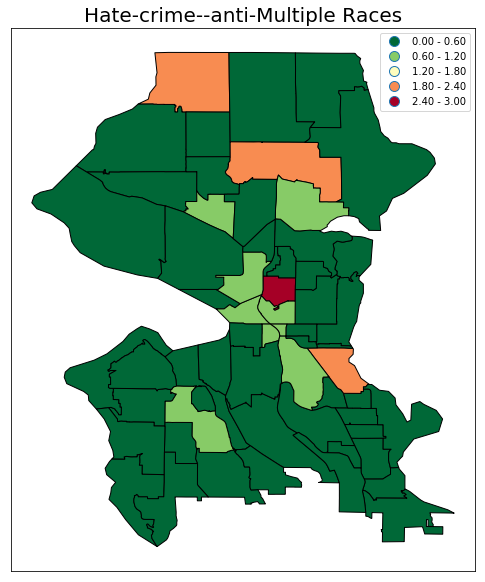

In [43]:
draw(seattle_geod,'anti-Multiple Races','anti-Multiple Races',5,(10,10),'Hate-crime','pro')

Hate-crime--anti-Gender


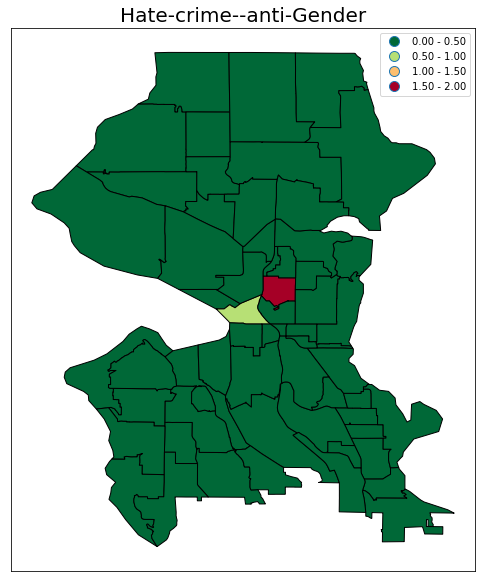

In [44]:
draw(seattle_geod,'anti-Gender','anti-Gender',4,(10,10),'Hate-crime','pro')

Hate-crime--racialism all


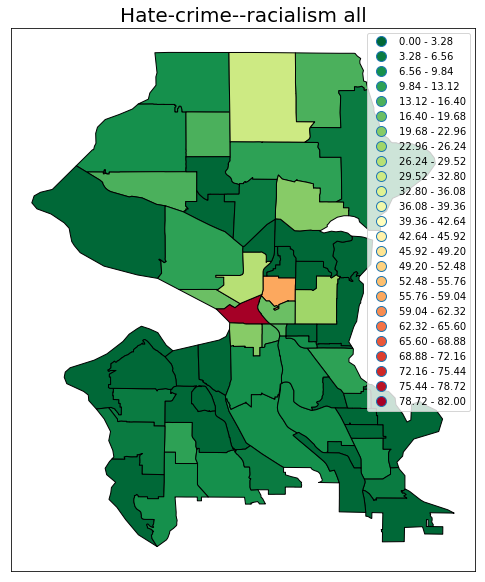

In [45]:
seattle_geod['racialism'] = seattle_geod['anti-Asian'] + seattle_geod['anti-Asian/Pacific Islander'] + seattle_geod['anti-Black'] +seattle_geod['anti-Hispanic'] +seattle_geod['anti-White']
draw(seattle_geod,'racialism','racialism all',25,(10,10),'Hate-crime','pro')

Hate-crime--homophobia all


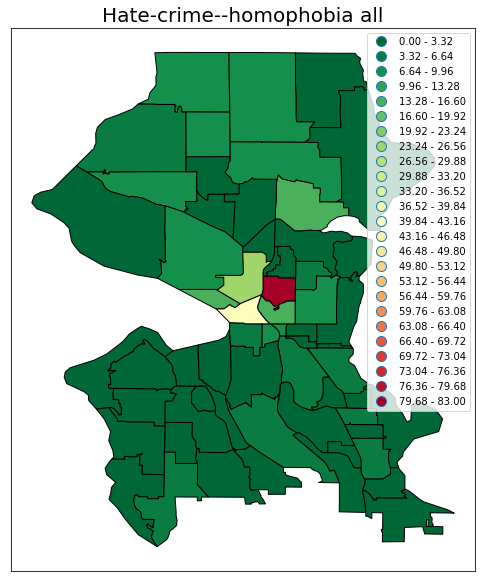

In [46]:
seattle_geod['homophobia'] = seattle_geod['anti-Bisexual'] + seattle_geod['anti-Gay'] + seattle_geod['anti-Gay/Lesbian'] +seattle_geod['anti-Gender Non-Conforming'] +seattle_geod['anti-Lesbian'] + seattle_geod['anti-Transgender']+ seattle_geod['anti-Multiple Races'] + seattle_geod['anti-Gender'] 
draw(seattle_geod,'homophobia','homophobia all',25,(10,10),'Hate-crime','pro')

####  covariate analysis for seattle

In [47]:
corr_table_for_Seattle=correlationHeatMap(seattle_zip_code_data)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [48]:
for i in corr_table_for_Seattle:
    if i[1] != []:
        str_l = ''
        for k in i[1]:
            str_l += '(' + k + ')'
        print(i[0] + ' has high covariation with :' + "[[[" +str_l +"]]]"+'\n')
    else:
        continue

White alone has high covariation with :[[[(Bachelor's degree)(Master's degree)(Median household income in the past 12 months)(Not Hispanic or Latino)(proportion of population born as USA citizens)]]]

Black or African American alone has high covariation with :[[[(No schooling completed)]]]

American Indian and Alaska Native alone has high covariation with :[[[(Income in the past 12 months below poverty level:)(11th grade)(Some college, less than 1 year)(Some college, 1 or more years, no degree)]]]

Asian alone has high covariation with :[[[(Income in the past 12 months below poverty level:)(Foreign born:)(No schooling completed)]]]

Native Hawaiian and Other Pacific Islander alone has high covariation with :[[[(Some other race alone)(Regular high school diploma)(Hispanic or Latino)]]]

Some other race alone has high covariation with :[[[(Native Hawaiian and Other Pacific Islander alone)(Foreign born:)(No schooling completed)(11th grade)(Regular high school diploma)(Some college, less t